In [54]:
import pandas as pd
import numpy as np
import datetime
import pickle
# matplot lib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# statmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# seaborn
import seaborn as sns

#sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('data/processed/arima_df.csv').set_index('date')
data.head(10)

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 11265.335750098899
Root Mean Squared Error (RMSE): 14959.893465091778
R2 Score: 0.9835642876259857


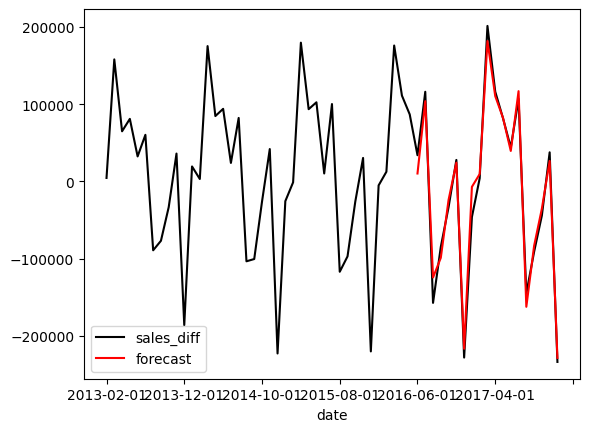

In [60]:
# Model
sar = sm.tsa.statespace.SARIMAX(
    endog=data.sales_diff, 
    seasonal_order=(0,1,0,12), 
    order=(12,0,0), 
    trend='c')

model = sar.fit(transformed=True, method='lbfgs')

# forecast
start, stop, dynamic = 40, 100, 7
data['forecast'] = model.predict(start=start, end=stop, dynamic=dynamic) 
pred_df = data.forecast[start+dynamic:stop]

data[['sales_diff', 'forecast']].plot(color=['black', 'Red'])

model_scores = {}

rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
model_scores['ARIMA'] = [rmse, mae, r2]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")

pickle.dump(model_scores, open( "model/arima_model_scores.p", "wb" ))

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          sales_diff   No. Observations:                   59
Model:             SARIMAX(12, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -520.381
Date:                             Thu, 28 Sep 2023   AIC                           1068.761
Time:                                     08:20:36   BIC                           1094.663
Sample:                                 02-01-2013   HQIC                          1078.508
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -739.1753   1700.249     -0.435      0.664   -4071.602    2593.251
ar.L1          0.0035      0.104      0.034      0.973      -0.200       0.207
ar.L2         -0.0713      0.112     -0.636      0.525      -0.291       0.148
ar.L3          0.0158      0.137      0.116      0.908      -0.252       0.284
ar.L4         -0.0092      0.099     -0.093      0.926      -0.203       0.184
ar.L5          0.0531      0.072      0.740      0.459      -0.088       0.194
ar.L6          0.0268      0.083      0.324      0.746      -0.135       0.189
ar.L7         -0.1364      0.055     -2.459      0.014      -0.245      -0.028
ar.L8         -0.0202      0.074     -0.274      0.784      -0.165       0.124
ar.L9          0.0284      0.089      0.318      0.750      -0.147       0.204
ar.L10        -0.0559      0.092     -0.605      0.545      -0.237       0.125
ar.L11         0.0193      0.060      0.321      0.748      -0.099       0.137
ar.L12         0.1266      0.051      2.460      0.014       0.026       0.227
sigma2      1.253e+08      0.047   2.69e+09      0.000    1.25e+08    1.25e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                10.54
Prob(Q):                              0.66   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                            -0.89
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+25. Standard errors may be unstable.
"""

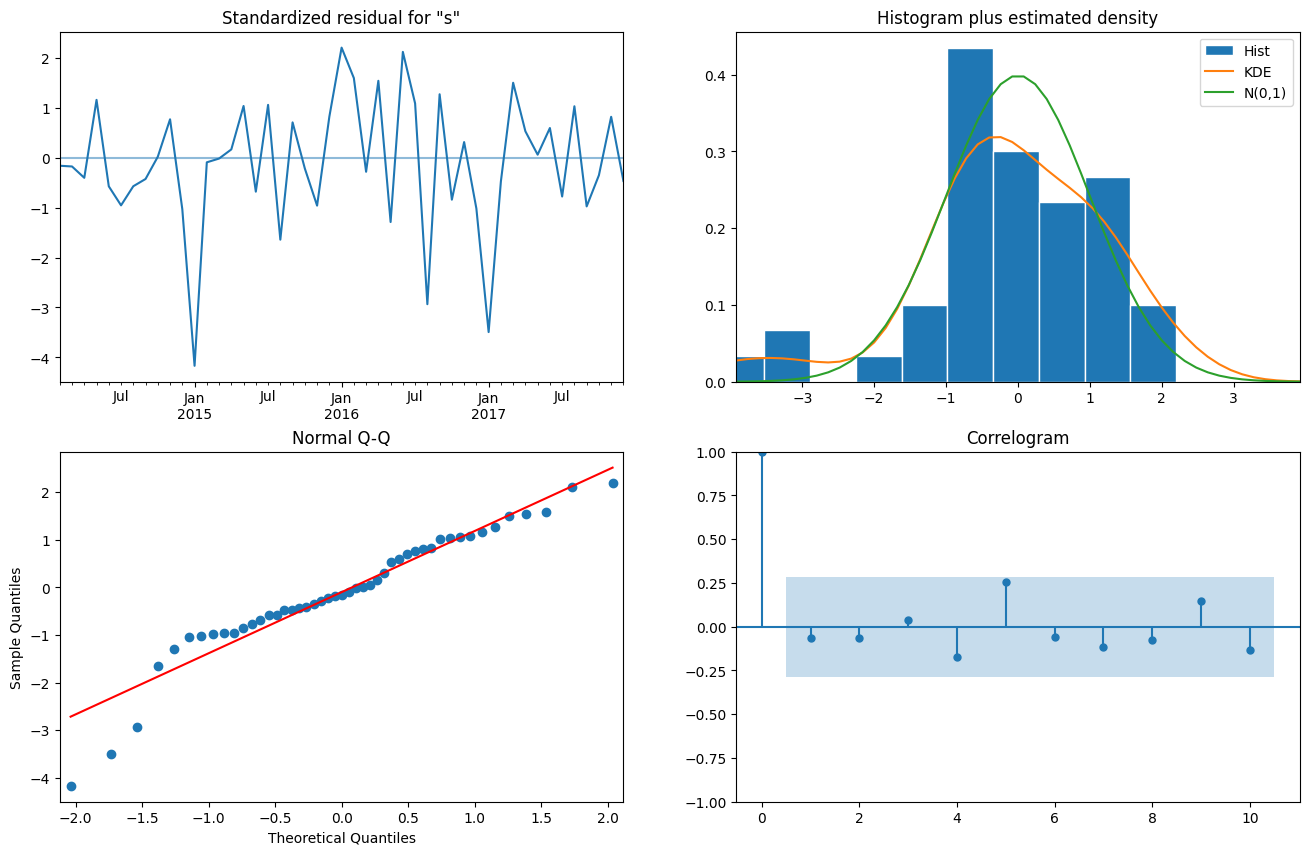

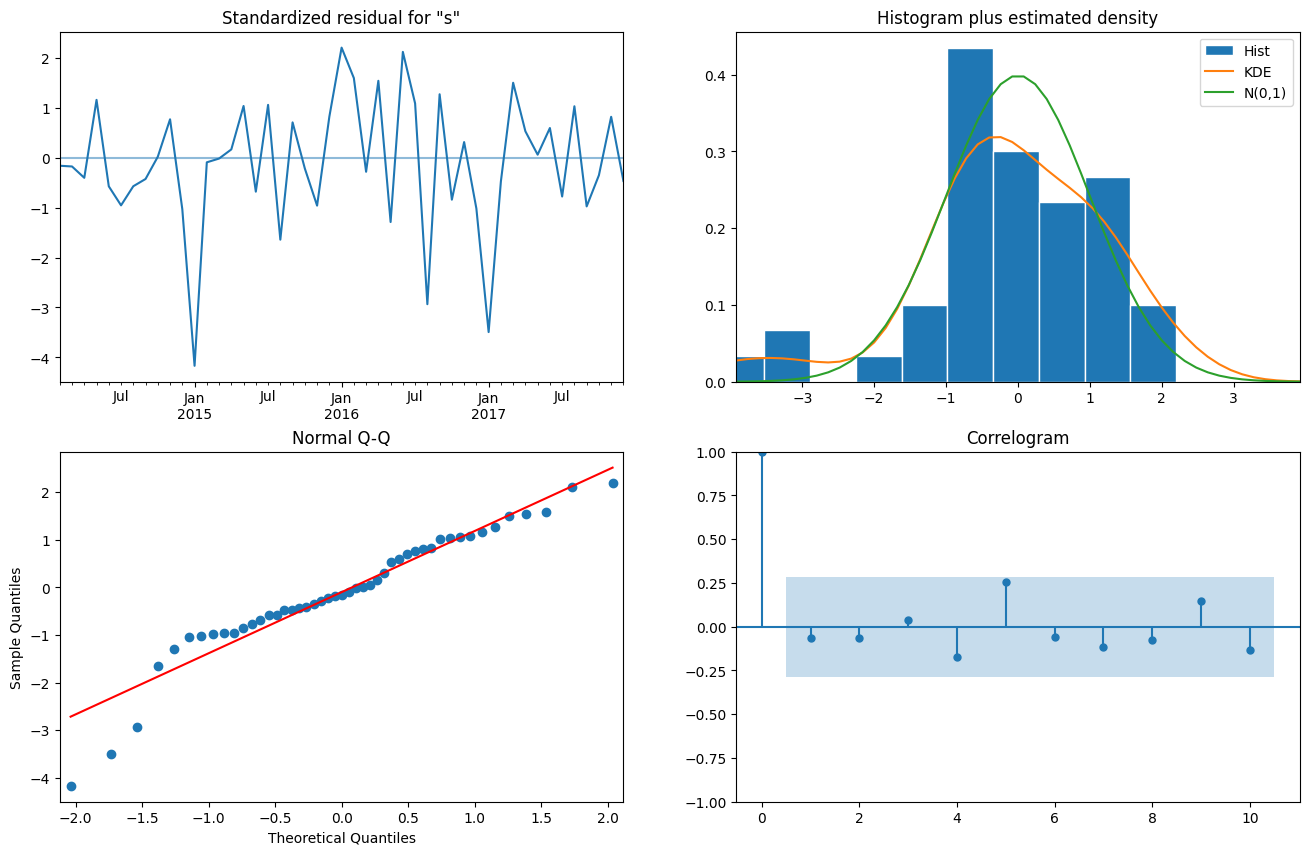

In [ ]:

model.plot_diagnostics(figsize=(16, 10))

C:\Users\klaud\AppData\Local\Temp\ipykernel_15808\3268419122.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\klaud\OneDrive\Documentos\sales-forecasting-v2\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\klaud\OneDrive\Documentos\sale

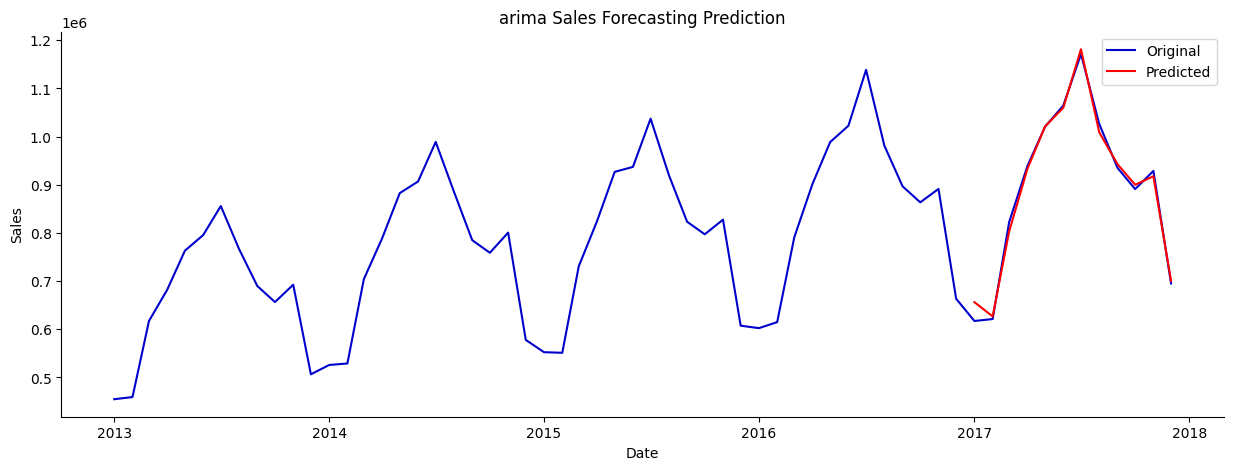

In [ ]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.date, y=original_df.sales, data=original_df, ax=ax, 
                label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'model/{model_name}_forecast.png')

prediction_df, original_df = predict_df(pred_df)
plot_results(prediction_df, original_df, 'arima')